<a href="https://colab.research.google.com/github/kavyajeetbora/ETL_wages/blob/master/WIOD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installation and Import

To Download any pandas dataframe to exel, follow this code:
Here `world_industry_values` is python variable of pd.DataFrame type

```python
world_industry_values.to_excel('filename.xlsx')
```

In [1]:
%%time

## Installation of external files
!wget -q https://dataverse.nl/api/access/datafile/199104 -O wiot.zip
!wget -q https://dataverse.nl/api/access/datafile/199097 -O exchange_rates.xlsx
!wget -q https://dataverse.nl/api/access/datafile/199095 -O sea.xlsx
!wget -q https://dataverse.nl/api/access/datafile/354108 -O NA_data.xlsx
!wget -q https://raw.githubusercontent.com/kavyajeetbora/ETL_wages/master/data/PPP_export.csv -O ppp.csv

## Installation of external python libraries
!pip install -q pyxlsb

CPU times: user 518 ms, sys: 80.9 ms, total: 599 ms
Wall time: 57.6 s


In [2]:
%%time

import pandas as pd
from zipfile import ZipFile
from tqdm import tqdm
import seaborn as sns
from pyxlsb import open_workbook as open_xlsb
from glob import glob

CPU times: user 1.34 s, sys: 139 ms, total: 1.48 s
Wall time: 1.9 s


## SEA

In [3]:
%%time
sea = pd.read_excel("sea.xlsx", sheet_name='DATA')

CPU times: user 16.7 s, sys: 203 ms, total: 16.9 s
Wall time: 26.5 s


In [4]:
sea.head(3)

,country,variable,description,code,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
0,AUS,CAP,"Crop and animal production, hunting and relate...",A01,9739.77,13729.03,9726.30,11808.62,11163.98,12429.90,8706.66,11227.29,12556.71,13768.79,18441.27,20106.04,19659.28,18986.06,20525.22
1,AUS,CAP,Forestry and logging,A02,582.69,740.04,540.79,651.96,649.34,676.64,549.27,616.70,716.86,749.91,894.94,923.40,1001.44,1247.96,1206.44
2,AUS,CAP,Fishing and aquaculture,A03,869.31,1122.29,652.69,1024.72,1059.83,923.46,904.15,863.98,1146.37,1108.94,1116.14,1213.94,1182.11,1388.98,1475.22


In [5]:
year_range = list(range(2000,2015))

## Convert to USD $

In [6]:
exchange = pd.read_excel('exchange_rates.xlsx', sheet_name='EXR', header=3)
exchange.columns = list(exchange.columns[:2].str.lower()) + [int(c.replace("_", "")) for c in exchange.columns[2:]]
exchange.loc[exchange['acronym']=='ROM', 'acronym'] = 'ROU'
exchange = pd.melt(exchange, id_vars=['acronym'], value_vars=list(range(2000,2015)), var_name='Year')
exchange.head(3)

,acronym,Year,value
0,AUS,2000,0.582346
1,AUT,2000,0.923600
2,BEL,2000,0.923600


In [7]:
SEA = pd.melt(sea, id_vars=['country','variable','code'], value_vars= year_range, var_name='year')
SEA.head(3)

,country,variable,code,year,value
0,AUS,CAP,A01,2000,9739.77
1,AUS,CAP,A02,2000,582.69
2,AUS,CAP,A03,2000,869.31


In [8]:
SEA_USD = pd.merge(left=SEA,
         right=exchange,
         how='left',
         left_on=SEA['country']+SEA['year'].astype(str),
         right_on=exchange['acronym']+exchange['Year'].astype(str),
         suffixes=('', '_y')
)

SEA_USD['value'] = SEA_USD['value']*SEA_USD['value_y']
SEA_USD = SEA_USD.drop(['key_0', 'value_y', 'acronym', 'Year'], axis=1)

## Unpivot changes
SEA_USD = SEA_USD.pivot(columns=['year'], index=['country','variable', 'code'], values='value').reset_index()
SEA_USD.head(3)

year,country,variable,code,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
0,AUS,CAP,A01,5671.916100,7106.640173,5290.163749,7697.850440,8223.153224,9494.504536,6559.162311,9414.767530,10739.314578,10895.298602,16956.729324,20753.655548,20363.082224,18386.613128,18528.013468
1,AUS,CAP,A02,339.327191,383.071345,294.137303,425.002293,478.290208,516.847404,413.792554,517.140569,613.105268,593.406783,822.896435,953.142714,1037.291552,1208.558159,1089.047356
2,AUS,CAP,A03,506.239201,580.937706,355.000049,667.998572,780.648522,705.379380,681.141402,724.499933,980.450138,877.508658,1026.289614,1253.041007,1224.429538,1345.125734,1331.673718


## Adjusted USD $

In [9]:
GO_PI = sea.loc[sea['variable']=='GO_PI'].copy()
GO_PI[GO_PI.columns[4:]] = GO_PI[GO_PI.columns[4:]]/100
GO_PI = pd.melt(GO_PI, id_vars=['country','variable', 'code'], value_vars=year_range, var_name='Year')
GO_PI.head(3)

,country,variable,code,Year,value
0,AUS,GO_PI,A01,2000,0.91576
1,AUS,GO_PI,A02,2000,0.91576
2,AUS,GO_PI,A03,2000,0.91576


In [10]:
adj_USD = pd.merge(left=SEA,
         right=GO_PI,
         how='left',
         left_on=SEA['country']+SEA['year'].astype(str)+SEA['code'],
         right_on=GO_PI['country']+GO_PI['Year'].astype(str)+GO_PI['code'],
         suffixes=('', '_y')
)
adj_USD['value'] = adj_USD['value']*adj_USD['value_y']
adj_USD = adj_USD.drop(['key_0', 'country_y','variable_y','code_y', 'Year', 'value_y'], axis=1)

## Unpivot changes
adj_USD = adj_USD.pivot(columns=['year'], index=['country','variable', 'code'], values='value').reset_index()
adj_USD.sample(4)

year,country,variable,code,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
28087,NLD,GO_PI,H50,8.410908e+01,8.373165e+01,8.523167e+01,8.826790e+01,9.242900e+01,1.016689e+02,1.024569e+02,9.578733e+01,1.043462e+02,9.451728e+01,100.00,1.071784e+02,1.101219e+02,1.129268e+02,1.114883e+02
10519,DNK,K,M73,3.702238e+03,4.134029e+03,3.862077e+03,3.807131e+03,3.870527e+03,3.608004e+03,3.475747e+03,3.688459e+03,3.834820e+03,3.764687e+03,3610.00,3.381976e+03,3.220782e+03,3.102627e+03,2.934607e+03
18145,IDN,GO,A02,8.040057e+06,9.141214e+06,1.037350e+07,1.067033e+07,1.220327e+07,1.449259e+07,2.209142e+07,3.191728e+07,4.464623e+07,5.706782e+07,67712857.00,7.721270e+07,8.507871e+07,9.544399e+07,1.085286e+08
24404,LUX,EMPE,M69_M70,3.758692e+00,4.591388e+00,5.630467e+00,5.929464e+00,6.365140e+00,7.104056e+00,8.261572e+00,1.025850e+01,1.240595e+01,1.395384e+01,14.55,1.569370e+01,1.679187e+01,1.843743e+01,1.933492e+01


## Industry PPP in Adjusted USD $



In [11]:
ppp1 = adj_USD.groupby(['code','variable']).sum().reset_index()
ppp1 = ppp1.drop(['country'], axis=1)
ppp1[ppp1['variable']=='GO'].sample(5)

year,code,variable,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
308,C29,GO,9.785049e+07,1.169449e+08,1.267610e+08,1.375240e+08,1.600948e+08,1.938957e+08,2.338464e+08,2.786474e+08,3.797499e+08,3.839492e+08,4.489002e+08,5.281149e+08,5.687418e+08,6.405678e+08,7.029933e+08
356,C33,GO,5.299066e+05,5.413079e+05,5.786090e+05,6.139803e+05,6.683024e+05,6.992623e+05,7.509746e+05,8.082082e+05,8.313861e+05,8.824984e+05,9.644234e+05,1.041783e+06,1.105975e+06,1.179699e+06,1.274310e+06
292,C28,GO,6.389903e+07,7.098526e+07,7.681080e+07,8.005081e+07,9.697285e+07,1.169502e+08,1.345446e+08,1.503174e+08,1.873458e+08,2.055726e+08,2.340036e+08,2.601938e+08,2.755455e+08,2.853949e+08,3.288659e+08
484,H49,GO,6.475153e+07,7.792373e+07,8.898085e+07,1.097504e+08,1.278697e+08,1.781996e+08,2.664019e+08,2.802689e+08,3.550335e+08,3.329894e+08,3.877311e+08,4.234551e+08,4.645642e+08,5.591140e+08,6.888518e+08
68,C10-C12,GO,1.881692e+08,2.306442e+08,2.647098e+08,2.809759e+08,3.097317e+08,3.412415e+08,4.301856e+08,5.998739e+08,9.705961e+08,1.278884e+09,1.468689e+09,1.747287e+09,1.983977e+09,2.199417e+09,2.625205e+09


## Industry Total in Current Dollars

In [12]:
ppp2 = SEA_USD.groupby(['code','variable']).sum().reset_index()
ppp2 = ppp2.drop(['country'], axis=1)
ppp2[ppp2['variable']=='GO'].sample(5)

year,code,variable,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
292,C28,GO,1.135162e+06,1.081537e+06,1.087130e+06,1.250850e+06,1.474551e+06,1.633388e+06,1.850815e+06,2.206494e+06,2.528965e+06,2.163276e+06,2.382043e+06,2.866950e+06,2.872551e+06,2.977235e+06,3.060489e+06
548,H53,GO,1.915357e+05,1.918006e+05,2.013650e+05,2.231751e+05,2.478029e+05,2.596082e+05,2.738209e+05,3.000589e+05,3.171464e+05,2.889827e+05,2.979696e+05,3.266146e+05,3.256756e+05,3.325749e+05,3.491642e+05
52,B,GO,7.389781e+05,7.391038e+05,7.307282e+05,8.777288e+05,1.090986e+06,1.456242e+06,1.689578e+06,1.920450e+06,2.496300e+06,1.950009e+06,2.470418e+06,3.131768e+06,3.111180e+06,3.291677e+06,3.325762e+06
324,C30,GO,4.252458e+05,4.437103e+05,4.522351e+05,4.953466e+05,5.463972e+05,6.126742e+05,6.839720e+05,8.260728e+05,9.168611e+05,8.808356e+05,9.789932e+05,1.099602e+06,1.162483e+06,1.232618e+06,1.300536e+06
340,C31_C32,GO,5.984357e+05,5.784153e+05,5.932970e+05,6.369131e+05,6.818768e+05,7.673565e+05,8.416349e+05,9.368506e+05,9.773720e+05,8.821606e+05,8.917020e+05,9.879983e+05,1.029797e+06,1.055289e+06,1.079242e+06


## PPP Ratio

In [13]:
ppp_ratio = ppp2.copy()
ppp_ratio.loc[:,year_range] =  ppp2.loc[:,year_range] / ppp1.loc[:,year_range]
ppp_ratio.sample(5)

year,code,variable,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
121,C17,II_PI,0.687338,0.643664,0.675120,0.769573,0.843260,0.852398,0.841818,0.887013,0.902482,0.840316,0.795345,0.797436,0.740769,0.743315,0.724463
460,G46,LAB,0.012744,0.010419,0.009763,0.009823,0.009926,0.009039,0.008160,0.007033,0.006459,0.005384,0.004525,0.004206,0.004018,0.003578,0.003089
247,C25,H_EMPE,0.775140,0.713954,0.703197,0.738783,0.726338,0.698737,0.694163,0.710419,0.683617,0.628829,0.599618,0.593832,0.537512,0.524950,0.506135
297,C28,II_PI,0.724524,0.668146,0.689427,0.793409,0.851396,0.830284,0.832816,0.888270,0.911806,0.806747,0.795345,0.817434,0.738361,0.729172,0.704476
392,E36,II,0.015492,0.013567,0.012144,0.011450,0.010034,0.008901,0.008630,0.009264,0.006385,0.007702,0.007734,0.006337,0.005129,0.004976,0.004200


## Load PPP Exchange Rate


$V_{GDP} / PPP$

In [14]:
PPP = pd.read_csv('ppp.csv')
PPP = pd.melt(PPP, id_vars=['ISO code','Country', 'Variable code', 'Variable name'], value_vars=[str(i) for i in year_range], var_name='year')
PPP.head(3)

,ISO code,Country,Variable code,Variable name,year,value
0,ABW,Aruba,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2000,4519.512695
1,AGO,Angola,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2000,37817.11719
2,AIA,Anguilla,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2000,273.9180298


In [15]:
NA_data = pd.read_excel('NA_data.xlsx', sheet_name='Data')
NA_data = NA_data[NA_data['year'].isin(year_range)][['countrycode', 'year', 'v_gdp']]
NA_data.head(3)

,countrycode,year,v_gdp
30,ABW,2000,3514.117257
31,ABW,2001,3601.926718
32,ABW,2002,3640.996725


In [16]:
PPP_exchange = pd.merge(left=PPP,
         right=NA_data,
         how='left',
         left_on=PPP['ISO code']+PPP['year'].astype(str),
         right_on=NA_data['countrycode']+NA_data['year'].astype(str),
         suffixes=('', '_y')
)
PPP_exchange['value'] = PPP_exchange['value'].str.replace(',','').astype(float)
PPP_exchange['value'] = PPP_exchange['value']/PPP_exchange['v_gdp']

PPP_exchange = PPP_exchange.drop(['key_0', 'countrycode','year_y','v_gdp'], axis=1)
PPP_exchange.dropna(inplace=True)
PPP_exchange

,ISO code,Country,Variable code,Variable name,year,value
0,ABW,Aruba,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2000,1.286102
1,AGO,Angola,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2000,0.308539
2,AIA,Anguilla,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2000,0.675270
3,ALB,Albania,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2000,0.031809
4,ARE,United Arab Emirates,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2000,0.919793
...,...,...,...,...,...,...
2852,VNM,Viet Nam,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2014,0.000136
2853,YEM,Yemen,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2014,0.013124
2854,ZAF,South Africa,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2014,0.183780
2855,ZMB,Zambia,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2014,0.320689


## Industry PPP Exchange Rate

In [17]:
countries = SEA['country'].unique()
PPP_exchage_filtered = PPP_exchange[PPP_exchange['ISO code'].isin(countries)].drop(['Variable code','Variable name'], axis=1)
PPP_exchage_filtered.head(3)

,ISO code,Country,year,value
8,AUS,Australia,2000,1.056050
9,AUT,Austria,2000,1.447184
12,BEL,Belgium,2000,1.421313


<Axes: xlabel='year', ylabel='value'>

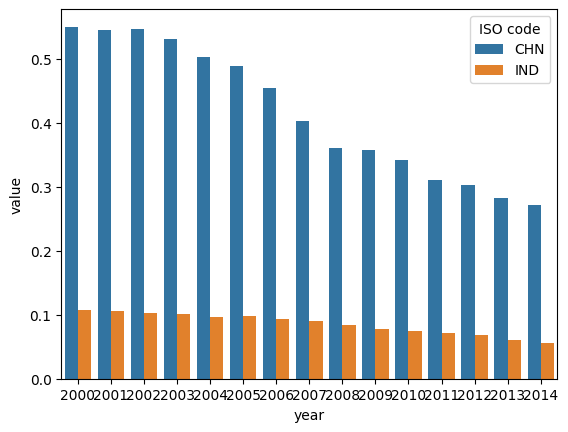

In [18]:
data_filter = PPP_exchage_filtered.loc[(PPP_exchage_filtered['ISO code'].isin(['IND','CHN']))]
sns.barplot(data=data_filter, x='year', y='value', hue='ISO code')

In [19]:
SEA.head()

,country,variable,code,year,value
0,AUS,CAP,A01,2000,9739.77
1,AUS,CAP,A02,2000,582.69
2,AUS,CAP,A03,2000,869.31
3,AUS,CAP,B,2000,28250.15
4,AUS,CAP,C10-C12,2000,6401.86


In [20]:
%%time

ind_ppps = []
for (country,year),dfx in tqdm(SEA.groupby(['country','year']), unit=' country'):
    X_ppp = PPP_exchage_filtered.loc[(PPP_exchage_filtered['year']==str(year)) & (PPP_exchage_filtered['ISO code']==country)]['value'].values[0]
    dfx['tot_ind_ppp'] = dfx['value']*X_ppp

    ind_ppps.append(dfx)

tot_ind_ppp_df = pd.concat(ind_ppps).reset_index()
tot_ind_ppp_df.head()

100%|██████████| 645/645 [00:00<00:00, 726.32 country/s]


CPU times: user 2.08 s, sys: 103 ms, total: 2.19 s
Wall time: 2.23 s


,index,country,variable,code,year,value,tot_ind_ppp
0,0,AUS,CAP,A01,2000,9739.77,10285.682219
1,1,AUS,CAP,A02,2000,582.69,615.349661
2,2,AUS,CAP,A03,2000,869.31,918.034657
3,3,AUS,CAP,B,2000,28250.15,29833.565426
4,4,AUS,CAP,C10-C12,2000,6401.86,6760.683011


<Axes: xlabel='year', ylabel='tot_ind_ppp'>

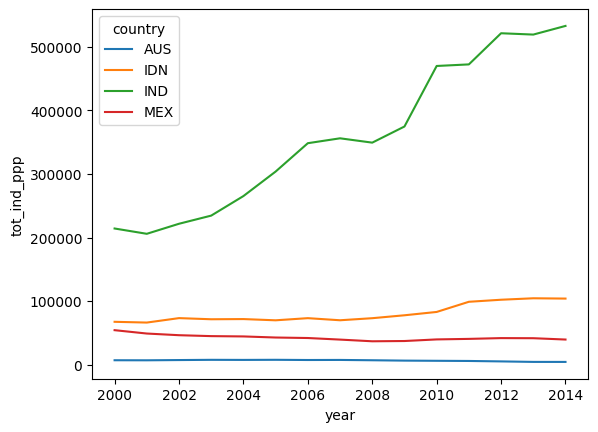

In [21]:
data_filter = tot_ind_ppp_df.loc[(tot_ind_ppp_df['country'].isin(['IND','AUS', 'IDN', "MEX"])) & (tot_ind_ppp_df['code']=='C13-C15') & (tot_ind_ppp_df['variable']=='GO')]
sns.lineplot(data=data_filter, x='year', y='tot_ind_ppp', hue='country')

In [22]:
tot_ind_ppp_df_GO = tot_ind_ppp_df[tot_ind_ppp_df['variable']=='GO']
tot_ind_ppp_df_GO = tot_ind_ppp_df_GO.groupby(['code','year']).sum().reset_index().drop(['country','value','variable','index'], axis=1)
tot_ind_ppp_df_GO.head()

,code,year,tot_ind_ppp
0,A01,2000,3.508316e+06
1,A01,2001,3.605992e+06
2,A01,2002,3.598810e+06
3,A01,2003,3.736123e+06
4,A01,2004,4.060107e+06


In [23]:
SEA_USD_x = pd.melt(SEA_USD, id_vars=['country', 'code', 'variable'], value_vars=year_range)
SEA_USD_x = SEA_USD_x.loc[SEA_USD_x['variable']=="GO"]
SEA_USD_x = SEA_USD_x.groupby(['code','year']).sum().reset_index().drop(['country','variable'], axis=1)

SEA_USD_x['SEA_by_PPP'] = SEA_USD_x['value']/tot_ind_ppp_df_GO['tot_ind_ppp']
SEA_USD_x.drop('value', axis=1, inplace=True)
print(SEA_USD_x.shape)
SEA_USD_x.head(5)

(840, 3)


,code,year,SEA_by_PPP
0,A01,2000,0.364607
1,A01,2001,0.354486
2,A01,2002,0.359874
3,A01,2003,0.394123
4,A01,2004,0.420667


In [24]:
PPP_exchage_filtered.head()

,ISO code,Country,year,value
8,AUS,Australia,2000,1.056050
9,AUT,Austria,2000,1.447184
12,BEL,Belgium,2000,1.421313
16,BGR,Bulgaria,2000,2.679952
24,BRA,Brazil,2000,1.352885


In [25]:
%%time
ind_ex_rates = []
for (country,year),dfx in tqdm(PPP_exchage_filtered.groupby(['Country','year']), unit=' country'):
    ppp_ex = dfx['value'].values[0]
    sea_by_ppp_x = SEA_USD_x[SEA_USD_x['year']==int(year)].copy()
    sea_by_ppp_x['country'] = dfx['ISO code'].values[0]
    sea_by_ppp_x['ind_ppp_ex'] = sea_by_ppp_x['SEA_by_PPP']*ppp_ex

    ind_ex_rates.append(sea_by_ppp_x)

ind_ex_rate = pd.concat(ind_ex_rates).reset_index(drop=True)
ind_ex_rate.head()

100%|██████████| 645/645 [00:01<00:00, 556.73 country/s]


CPU times: user 1.21 s, sys: 26.5 ms, total: 1.24 s
Wall time: 1.25 s


,code,year,SEA_by_PPP,country,ind_ppp_ex
0,A01,2000,0.364607,AUS,0.385043
1,A02,2000,0.389933,AUS,0.411789
2,A03,2000,0.353583,AUS,0.373401
3,B,2000,0.432509,AUS,0.456751
4,C10-C12,2000,0.516493,AUS,0.545442


### Country Industry PPP

In [26]:
SEA_GO = SEA[SEA['variable']=="GO"].drop('variable',axis=1).copy()
country_ind_ppp = pd.merge(
    left=SEA_GO,
    right=ind_ex_rate,
    left_on = SEA_GO['country']+SEA_GO['code']+SEA_GO['year'].astype(str),
    right_on =ind_ex_rate['country']+ind_ex_rate['code']+ind_ex_rate['year'].astype(str),
    suffixes=('', '_y'),
    how='inner'
)


country_ind_ppp['country_ind_ppp'] = country_ind_ppp['value']*country_ind_ppp['ind_ppp_ex']

country_ind_ppp = country_ind_ppp.drop(['key_0', 'code_y','year_y','SEA_by_PPP', 'country_y'], axis=1)
country_ind_ppp.dropna(inplace=True)
country_ind_ppp.sample(5)

,country,code,year,value,ind_ppp_ex,country_ind_ppp
1278,IRL,M72,2000,396.6,0.963167,381.992106
28111,LVA,U,2011,0.0,1.211929,0.000000
3134,ESP,T,2001,6158.0,1.093514,6733.856450
7200,USA,H51,2002,100688.0,0.756889,76209.618872
25435,JPN,C21,2010,6993600.0,0.007683,53731.084093


### World Industry Value

In [27]:
GO_industry_total = SEA_GO.groupby(['code','year']).sum().reset_index().drop(columns=['country'],axis=1)
GO_industry_total = GO_industry_total.rename(columns = {'value':'GO'})

SEA_HEMPE = SEA[SEA['variable']=="H_EMPE"].copy().drop(columns=['country', 'variable'],axis=1)
HEMPE_industry_total = SEA_HEMPE.groupby(['code','year']).sum().reset_index()
HEMPE_industry_total = HEMPE_industry_total.rename(columns = {'value':'H_EMPE'})

HEMPE_GO_ind_total = HEMPE_industry_total.set_index(['code','year']).join(GO_industry_total.set_index(['code','year'])).reset_index()
HEMPE_GO_ind_total.sample(3)

,code,year,H_EMPE,GO
151,C20,2001,10373.9880,1.670863e+08
408,G45,2003,20508.3712,1.740935e+08
381,E37-E39,2006,3073.1870,1.168339e+07


In [28]:
%%time
world_industry_values = []
for country,dfx in tqdm(country_ind_ppp.groupby(['country']), unit=' country'):
    world_industry_value = pd.merge(
        left=dfx,
        right=HEMPE_GO_ind_total,
        left_on = dfx['code']+dfx['year'].astype(str),
        right_on =HEMPE_GO_ind_total['code']+HEMPE_GO_ind_total['year'].astype(str),
        suffixes=('', '_y'),
        how='inner'
    )

    world_industry_value = world_industry_value.drop(['key_0', 'code_y','year_y'], axis=1)

    world_industry_values.append(world_industry_value)

world_industry_values = pd.concat(world_industry_values).reset_index(drop=True)
world_industry_values.head()

100%|██████████| 43/43 [00:00<00:00, 168.88 country/s]

CPU times: user 262 ms, sys: 2.92 ms, total: 265 ms
Wall time: 278 ms


,country,code,year,value,ind_ppp_ex,country_ind_ppp,H_EMPE,GO
0,AUS,A01,2000,49709.210,0.385043,19140.186311,260801.8294,2.818576e+08
1,AUS,A02,2000,2586.232,0.411789,1064.981635,25176.0964,2.897634e+07
2,AUS,A03,2000,2597.053,0.373401,969.741863,12209.6857,3.470360e+07
3,AUS,B,2000,58406.047,0.456751,26677.002857,11952.2797,2.062574e+08
4,AUS,C10-C12,2000,58673.688,0.545442,32003.105786,38579.8683,4.026327e+08


### Calculate homogeneous Labour

In [29]:
world_industry_values['hom_labour'] = world_industry_values['country_ind_ppp']*world_industry_values['H_EMPE']/world_industry_values['GO']
world_industry_values.head()

,country,code,year,value,ind_ppp_ex,country_ind_ppp,H_EMPE,GO,hom_labour
0,AUS,A01,2000,49709.210,0.385043,19140.186311,260801.8294,2.818576e+08,17.710345
1,AUS,A02,2000,2586.232,0.411789,1064.981635,25176.0964,2.897634e+07,0.925310
2,AUS,A03,2000,2597.053,0.373401,969.741863,12209.6857,3.470360e+07,0.341182
3,AUS,B,2000,58406.047,0.456751,26677.002857,11952.2797,2.062574e+08,1.545888
4,AUS,C10-C12,2000,58673.688,0.545442,32003.105786,38579.8683,4.026327e+08,3.066506


In [30]:
# world_industry_values.to_excel('world_industry_values.xlsx')

### Plotting Homogeneous Labour in $

<Axes: xlabel='year', ylabel='hom_labour'>

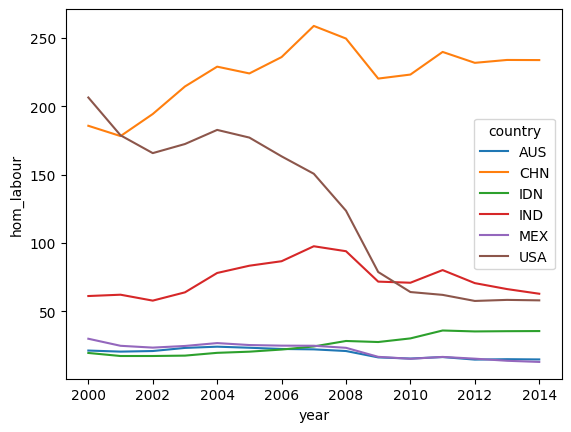

In [31]:
countries = ['IND','AUS', 'IDN', "MEX", "CHN", "USA"]
data_filter = world_industry_values.loc[(world_industry_values['country'].isin(countries)) & (world_industry_values['code']=='F')]
sns.lineplot(data=data_filter, x='year', y='hom_labour', hue='country')

In [32]:
world_industry_values.describe()

,value,ind_ppp_ex,country_ind_ppp,H_EMPE,GO,hom_labour
count,3.612000e+04,36120.000000,3.612000e+04,36120.000000,3.612000e+04,36120.000000
mean,5.619546e+06,0.685653,3.922423e+04,30689.717916,2.416405e+08,7.269695
std,5.325138e+07,0.527020,1.351723e+05,46082.054314,3.378267e+08,31.752405
min,0.000000e+00,0.000131,0.000000e+00,0.047000,5.333060e+02,0.000000
25%,1.330175e+03,0.110109,1.040668e+03,5377.553750,4.553640e+07,0.117451
50%,1.417800e+04,0.707232,5.738215e+03,13112.225500,1.357937e+08,0.716327
75%,9.733963e+04,1.057976,2.497810e+04,27806.747975,3.130893e+08,3.601492
max,3.027433e+09,3.629009,3.550996e+06,262589.921600,3.359589e+09,1218.587163


## International Market Value (MV)


In [33]:
SEA_USD_melt = pd.melt(SEA_USD, id_vars=['country','variable','code'], value_vars= year_range, var_name='year')
SEA_USD_GO_sum = SEA_USD_melt[['variable', 'value','year']][SEA_USD_melt['variable']=='GO'].groupby('year').sum().drop('variable', axis=1).reset_index()
SEA_HEMPE_sum = SEA[['variable', 'value','year']][SEA['variable']=='H_EMPE'].groupby('year').sum().drop('variable', axis=1).reset_index()

MEV = SEA_HEMPE_sum.copy().drop(['value'],axis=1)
MEV['MEV'] = SEA_USD_GO_sum['value']/SEA_HEMPE_sum['value']
MEV

,year,MEV
0,2000,35.672182
1,2001,35.106767
2,2002,36.289156
3,2003,40.565310
4,2004,44.970490
5,2005,48.518267
6,2006,51.818365
7,2007,57.581716
8,2008,63.241141
9,2009,59.048367


In [34]:
SEA_USD[SEA_USD['variable'].isin(['K','GO']) & SEA_USD['country'].isin(['AUS','IND','IDN']) & SEA_USD['code'].isin(['A01'])]

year,country,variable,code,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
224,AUS,GO,A01,28947.959607,30957.684782,25292.346147,34889.990730,39645.927147,42012.510005,36429.086769,46225.675125,50077.341148,45742.080250,59637.655072,69566.630072,71514.739400,71459.259903,70292.034587
616,AUS,K,A01,39799.823577,36621.912053,39886.941034,51153.411795,62475.631242,69397.728989,74810.750515,89284.205980,95409.814050,89407.729743,105799.862882,121320.090125,125052.330802,117797.242582,112960.598377
18144,IDN,GO,A01,26971.930614,25978.475942,32278.221116,37957.120563,38814.652384,39611.879177,48107.168776,58850.741114,72528.226851,78402.845333,101622.948793,116266.943957,117716.880941,117162.620089,112492.713475
18536,IDN,K,A01,16485.304380,15055.093134,17338.851907,20624.442909,22571.328982,24128.696928,30555.346030,35150.640028,41541.671734,49670.246555,64298.781250,73679.169033,75924.637625,73993.512164,73186.723423
19040,IND,GO,A01,119836.589230,124203.712177,118370.122574,139227.773247,148234.818901,171203.461777,187717.798071,234165.135845,252618.261511,259166.931408,330669.957272,366814.957198,356133.418999,369830.454361,369345.847310
19432,IND,K,A01,144783.369345,150529.383671,155776.699764,177687.930507,204865.721118,225550.763288,241886.573458,294734.657913,319021.854878,316632.345067,373975.773299,418691.262178,432533.549308,466389.238891,474219.622470


In [35]:
SEA_USD_GO = SEA_USD_melt[SEA_USD_melt['variable']=='GO'].reset_index(drop=True)

SEA_USD_K = SEA_USD_melt[SEA_USD_melt['variable']=='K'].reset_index(drop=True)
SEA_USD_K.head()

,country,variable,code,year,value
0,AUS,K,A01,2000,39799.823577
1,AUS,K,A02,2000,1507.755523
2,AUS,K,A03,2000,2689.243546
3,AUS,K,B,2000,84688.831742
4,AUS,K,C10-C12,2000,12159.831139


### Calculate market price

In [36]:
WIV_x = world_industry_values[['country', 'code', 'year', 'hom_labour']].copy()
WIV_x

,country,code,year,hom_labour
0,AUS,A01,2000,17.710345
1,AUS,A02,2000,0.925310
2,AUS,A03,2000,0.341182
3,AUS,B,2000,1.545888
4,AUS,C10-C12,2000,3.066506
...,...,...,...,...
36115,USA,P85,2014,51.614154
36116,USA,Q,2014,560.397987
36117,USA,R_S,2014,85.154775
36118,USA,T,2014,90.079776


In [37]:
MVs=[]
for year, dfx in tqdm(WIV_x.groupby('year'), unit=' Year'):
    dfx['MEVLH'] = MEV.loc[MEV['year']==year,'MEV'].iloc[0]*dfx['hom_labour']
    MVs.append(dfx)

MV_data = pd.concat(MVs)
MV_data['K'] = SEA_USD_K['value']
MV_data['GO'] = SEA_USD_GO['value']
MV_data['MP'] = MV_data['K']+MV_data['GO']
MV_data['MV'] = MV_data['MEVLH']+MV_data['K']
MV_data['diff'] = MV_data['MP']-MV_data['MV']
MV_data.head(5)

100%|██████████| 15/15 [00:00<00:00, 741.22 Year/s]


,country,code,year,hom_labour,MEVLH,K,GO,MP,MV,diff
0,AUS,A01,2000,17.710345,631.766632,39799.823577,28947.959607,68747.783184,40431.590210,28316.192974
1,AUS,A02,2000,0.925310,33.007809,1507.755523,1506.081860,3013.837383,1540.763332,1473.074051
2,AUS,A03,2000,0.341182,12.170706,2689.243546,1512.383426,4201.626972,2701.414252,1500.212720
3,AUS,B,2000,1.545888,55.145213,84688.831742,34012.527846,118701.359588,84743.976955,33957.382633
4,AUS,C10-C12,2000,3.066506,109.388950,12159.831139,34168.387512,46328.218651,12269.220089,34058.998562


<Axes: xlabel='year', ylabel='diff'>

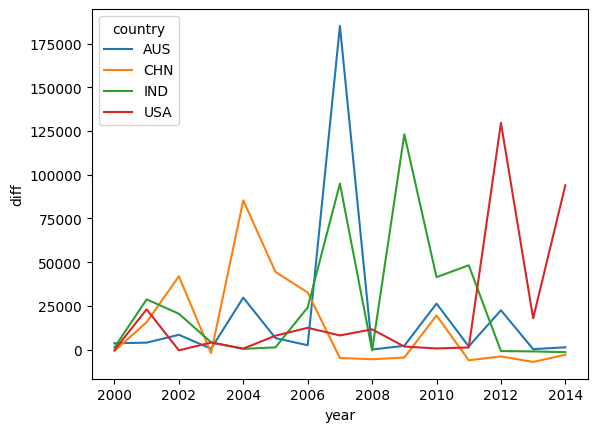

In [38]:
countries = ['IND','USA','AUS','CHN']
data_filter = MV_data.loc[(MV_data['country'].isin(countries)) & (MV_data['code']=='C13-C15')].copy()
sns.lineplot(data=data_filter, x='year', y='diff', hue='country')

In [39]:
MV_data['diff'].describe()

count    3.612000e+04
mean     3.883688e+04
std      1.320221e+05
min     -4.375939e+04
25%      7.823323e+02
50%      5.696780e+03
75%      2.600858e+04
max      3.403617e+06
Name: diff, dtype: float64

## World Input Output Analysis

### Exports

In [40]:
def extract_exports(df):
    columns = df.iloc[3,4:] +"_"+ df.iloc[4,4:]
    rows = df.iloc[5:-8,2] +"_"+ df.iloc[5:-8,3]
    countries = df.iloc[3,4:-1].values

    df_exp = df.iloc[5:-8, 4:].astype(float).copy().reset_index(drop=True)
    df_exp.columns=columns.values
    df_exp['supply'] = rows.values

    return df_exp

def filter_exports(df_exp):
    new_cols = []
    cols = [f"c{i}" for i in range(57,62)]
    for col in df_exp.columns[:-2]:
        country, ind = col.split("_")
        if ind in cols:
            new_cols.append(col)

    df_exp_filtered = df_exp[new_cols].copy()
    df_exp_filtered['supply'] = df_exp['supply']

    return df_exp_filtered

def calculate_exports(df_exp_filtered, df):

    exports = []

    for supply, dfx in df_exp_filtered.groupby('supply'):

        dfx = dfx.iloc[:,:-1]
        country,ind = supply.split("_")
        ind = ind.replace("_r","_c")
        sum_df = dfx.loc[:,(~dfx.columns.str.contains(country))]
        sum = sum_df.values.sum()

        exports.append([supply,sum])

    export_df = pd.DataFrame(exports, columns=['supply', 'exports'])

    exp_GO_sum = df.iloc[5:-8, -1].copy()
    exp_GO_sum.loc[exp_GO_sum.values==0] = float('nan')
    export_df['exports_total'] = export_df['exports'].divide(exp_GO_sum.values).fillna(0)
    return export_df

### Imports

In [41]:
def extract_imports(df):
    columns = df.iloc[3,4:-1] +"_"+ df.iloc[4,4:-1]
    rows = df.iloc[5:-8,2] +"_"+ df.iloc[5:-8,3]
    countries = df.iloc[3,4:-1].values

    df_Imp = df.iloc[5:-8, 4:-1].astype(float).copy().transpose().reset_index(drop=True)
    df_Imp.columns=rows.values
    df_Imp['supply'] = columns.values

    return df_Imp


def calculate_imports(df_Imp):
    Imports = []

    for supply, dfx in df_Imp.groupby('supply'):

        dfx = dfx.iloc[:,:-1]
        new_supply = supply.replace("_c","_r")
        new_cols = [c for c in dfx.columns if c!=new_supply]
        sum_df = dfx.loc[:,new_cols]
        sum = sum_df.values.sum()
        Imports.append([supply,sum])

    import_df = pd.DataFrame(Imports, columns=['supply', 'imports'])
    return import_df

def get_total_imports(df,import_df):
    imp_GO_sum = df.iloc[-1,4:-1].copy()
    imp_GO_sum.loc[imp_GO_sum.values==0] = float('nan')

    import_df['import_total'] = import_df['imports'].divide(imp_GO_sum.values).fillna(0)

    return import_df

### Calculate exports and imports for years

In [42]:
%%time

with ZipFile("wiot.zip", 'r') as zObject:
    zObject.extractall()

CPU times: user 6.4 s, sys: 1.72 s, total: 8.11 s
Wall time: 10.7 s


In [43]:
IO_files = glob('WIOT*_Nov16_ROW.xlsb')
print(f"Total Input Output files: {len(IO_files)} found")

Total Input Output files: 15 found


In [72]:
df = pd.read_excel('WIOT2000_Nov16_ROW.xlsb', engine='pyxlsb', nrows=10)
df.head()

,Intercountry Input-Output Table,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 2679,Unnamed: 2680,Unnamed: 2681,Unnamed: 2682,Unnamed: 2683,Unnamed: 2684,Unnamed: 2685,Unnamed: 2686,Unnamed: 2687,Unnamed: 2688
0,"43 countries, in current prices",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,(industry-by-industry),NaN,NaN,NaN,A01,A02,A03,B,C10-C12,C13-C15,...,CONS_np,CONS_g,GFCF,INVEN,CONS_h,CONS_np,CONS_g,GFCF,INVEN,GO
2,(millions of US$),NaN,NaN,NaN,"Crop and animal production, hunting and relate...",Forestry and logging,Fishing and aquaculture,Mining and quarrying,"Manufacture of food products, beverages and to...","Manufacture of textiles, wearing apparel and l...",...,Final consumption expenditure by non-profit or...,Final consumption expenditure by government,Gross fixed capital formation,Changes in inventories and valuables,Final consumption expenditure by households,Final consumption expenditure by non-profit or...,Final consumption expenditure by government,Gross fixed capital formation,Changes in inventories and valuables,Total output
3,NaN,NaN,NaN,NaN,AUS,AUS,AUS,AUS,AUS,AUS,...,USA,USA,USA,USA,ROW,ROW,ROW,ROW,ROW,TOT
4,NaN,NaN,NaN,NaN,c1,c2,c3,c4,c5,c6,...,c58,c59,c60,c61,c57,c58,c59,c60,c61,c62


In [101]:
df_industry = pd.DataFrame(list(zip(df.iloc[4, 4:4+56], df.iloc[1, 4:4+56])), columns = ['c_index', 'code'])
df_industry['r_index'] = df_industry['c_index'].str.replace("c",'r')
df_industry.head()

,c_index,code,r_index
0,c1,A01,r1
1,c2,A02,r2
2,c3,A03,r3
3,c4,B,r4
4,c5,C10-C12,r5


In [44]:
# %%time

# import_dfs = []
# export_dfs = []


# for file in tqdm(IO_files):
#     year = pd.ExcelFile(file).sheet_names[0]
#     df = pd.read_excel(file, engine='pyxlsb')

#     ## Calculate exports:
#     df_exp = extract_exports(df)
#     df_exp_filtered = filter_exports(df_exp)
#     export_df = calculate_exports(df_exp_filtered,df)
#     export_df['year'] = year

#     ## Calculate imports:
#     df_Imp = extract_imports(df)
#     import_df = calculate_imports(df_Imp)
#     total_imports = get_total_imports(df,import_df)
#     total_imports['year'] = year

#     ## Add to list
#     export_dfs.append(export_df)
#     import_dfs.append(import_df)

# imports_all = pd.concat(import_dfs)
# exports_all = pd.concat(export_dfs)

# exports_all.to_excel('exports.xlsx', index=False)
# imports_all.to_excel('imports.xlsx', index=False)

100%|██████████| 15/15 [20:24<00:00, 81.61s/it]

CPU times: user 19min 59s, sys: 18.1 s, total: 20min 17s
Wall time: 20min 24s


In [106]:
%%time
!wget -q https://github.com/kavyajeetbora/ETL_wages/raw/master/data/exports.xlsx -O exports.xlsx
!wget -q https://github.com/kavyajeetbora/ETL_wages/raw/master/data/imports.xlsx -O imports.xlsx

exports_all = pd.read_excel('exports.xlsx').sort_values(by='year')
exports_all[['country', 'r_index']] = exports_all['supply'].str.split('_').to_list()
exports_all = exports_all.drop('supply', axis=1)

## Merge industry to the imports
exports_all = pd.merge(
    left=exports_all,
    right=df_industry,
    how='inner',
    on='r_index'
)

exports_all = exports_all.drop(['c_index', 'r_index'],axis=1)

imports_all = pd.read_excel('imports.xlsx').sort_values(by='year')
imports_all[['country', 'c_index']] = imports_all['supply'].str.split('_').to_list()
imports_all = imports_all.drop('supply', axis=1)

## Merge industry to the imports
imports_all = pd.merge(
    left=imports_all,
    right=df_industry,
    how='inner',
    on='c_index'
)

imports_all = imports_all.drop(['c_index', 'r_index'],axis=1)

CPU times: user 9.44 s, sys: 54.5 ms, total: 9.5 s
Wall time: 10 s


In [118]:
exp_imp_df = pd.merge(
    left=imports_all,
    right=exports_all,
    on = ['code', 'country', 'year'],
    how='inner'
)

exp_imp_df.sample(5)

,imports,import_total,year,country,code,exports,exports_total
4779,12.676785,0.006084,2003,ROU,A03,0.940733,0.002329
19207,98572.472415,7.242547,2001,ROW,C24,451.352210,0.131053
24888,3584.179416,0.356132,2010,AUT,J62_J63,705.804649,0.214057
28089,12702.052468,0.136904,2008,CZE,L68,31.461304,0.003714
17089,12969.858612,0.000000,2013,POL,C20,2810.679503,15.877542


### Merge with DIFF

- MV['diff'] * exports_total on same industry, country and year
-

In [109]:
MV_data.sample(5)

,country,code,year,hom_labour,MEVLH,K,GO,MP,MV,diff
15062,GRC,T,2013,4.272842,290.152782,0.000000,8142.566000,8142.566000,290.152782,7852.413218
3178,BGR,K66,2011,0.110886,7.933502,16.562397,39.976047,56.538444,24.495900,32.042544
30494,RUS,H49,2004,27.555170,1239.169525,4660.511013,3397.656281,8058.167293,5899.680538,2158.486755
25716,MLT,C22,2009,0.003236,0.191070,1990.731398,17338.477641,19329.209039,1990.922468,17338.286571
32705,SVN,A02,2014,0.091453,6.112072,2954.867476,3378.264457,6333.131933,2960.979548,3372.152385


In [121]:
imports_diff = pd.merge(
    left = exp_imp_df,
    right = MV_data,
    on = ['country', 'code', 'year'],
    how='inner'
)
exp_imp_df['unequal_exchange'] = (exp_imp_df['exports_total'] - exp_imp_df['import_total'])*imports_diff['diff']
exp_imp_df.sample(5)

,imports,import_total,year,country,code,exports,exports_total,unequal_exchange
12623,2756.232369,0.531893,2001,NLD,C30,1542.524150,3.101073e-01,-574.627003
1073,17307.134201,0.723397,2009,POL,D35,96.183445,8.902091e-03,-8160.783706
28260,14761.821457,2.279145,2012,BRA,L68,643.113530,8.040485e-03,278.983057
35679,0.000000,0.000000,2000,ESP,T,-0.000014,-3.352710e-10,-0.000000
31399,8942.036065,0.000000,2008,TUR,M74_M75,73.255011,1.657394e-03,2.785915


<Axes: xlabel='year', ylabel='unequal_exchange'>

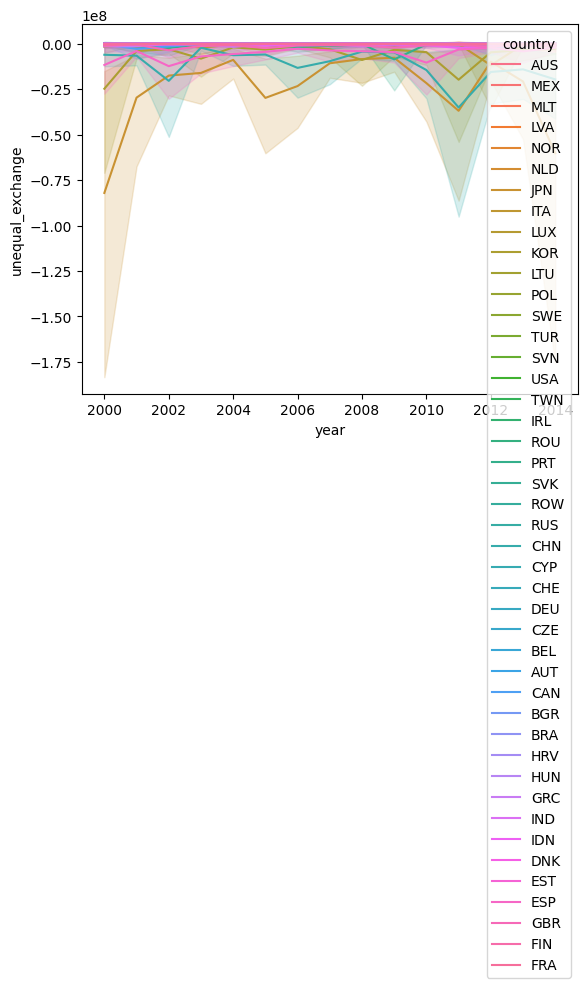

In [122]:

sns.lineplot(x='year', y='unequal_exchange', data=exp_imp_df, hue='country')